# Chapter 05 Understand How Stable Diffusion Works

In [ ]:
# The code in this notebook compatible with Diffusers with version 0.20.0
!pip uninstall diffusers
!pip install diffusers==0.20.0

## latent space

image weight:512 | image height:512


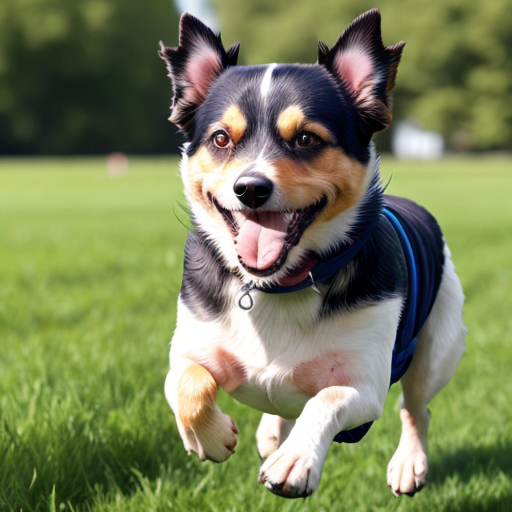

In [1]:
# load guided image
from diffusers.utils import load_image
image   = load_image("dog.png")
w,h     = image.size
print(f"image weight:{w} | image height:{h}")
display(image)

### Pre-Process image

In [2]:
# preprocess image
def preprocess(image):
    import numpy as np

    # convert image from 0 ~ 255 to 0 ~ 1
    image_array     = np.array(image).astype(np.float16)/255.0

    # convert the number from 0 ~ 1 to -1 ~ 1
    image_array     = image_array * 2.0 - 1.0    

    # transform the image array from width,height,channel to channel,width,height
    image_array_cwh = image_array.transpose(2,0,1)

    # add batch dimension 
    image_array_cwh = np.expand_dims(image_array_cwh, axis = 0)
    return image_array_cwh

image_array_cwh = preprocess(image)

print(image_array_cwh.shape)
#print(image_array_cwh)

(1, 3, 512, 512)


### Encode image to latent space

In [3]:
# image to latent
import torch
from diffusers import AutoencoderKL

# Initialize VAE model
vae_model = AutoencoderKL.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder = "vae"
    , torch_dtype = torch.float16
).to("cuda:0")

def image_to_latent(image_array_cwh):
    # load image with torch
    image_array_cwh = torch.from_numpy(image_array_cwh)
    image_array_cwh_cuda = image_array_cwh.to(
        "cuda:0"
    )
    
    # encode to latent 
    with torch.no_grad(): 
        latents = vae_model.encode(image_array_cwh_cuda).latent_dist.sample()
    return latents

latents_input = image_to_latent(image_array_cwh)
print(latents_input.shape)

torch.Size([1, 4, 64, 64])


### Decode latent to image (optional)

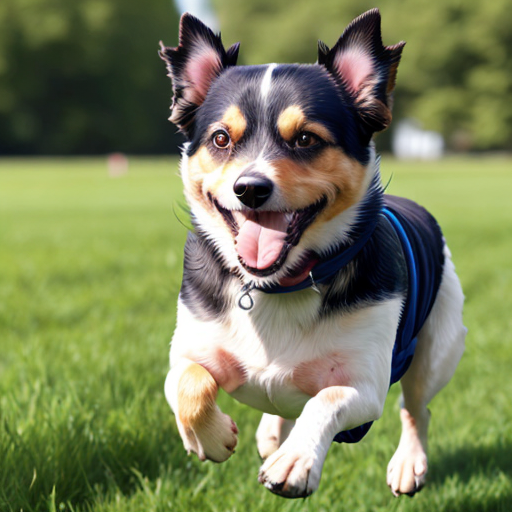

In [4]:
import numpy as np
from PIL import Image

def latent_to_img(latents_input):
    # decode image
    with torch.no_grad():
        decode_image = vae_model.decode(latents_input, return_dict = False)[0][0]

    decode_image =  (decode_image / 2 + 0.5).clamp(0, 1)

    # move latent data from cuda to cpu
    decode_image = decode_image.to("cpu")

    # convert torch tensor to numpy array
    numpy_img = decode_image.detach().numpy()

    # covert image array from (width, height, channel) to (channel, width, height)
    numpy_img_t = numpy_img.transpose(1,2,0)

    # map image data to 0, 255, and convert to to int number
    numpy_img_t_01_255 = (numpy_img_t*255).round().astype("uint8")

    # shape the pillow image object from the numpy array
    return Image.fromarray(numpy_img_t_01_255)

pil_img = latent_to_img(latents_input)
pil_img

## Generate text embeddings from prompt

In [5]:
input_prompt = "a running dog"

# input tokenizer and clip embedding model
from transformers import CLIPTokenizer,CLIPTextModel
import torch

# initialize tokenizer
clip_tokenizer = CLIPTokenizer.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder = "tokenizer"
    , dtype = torch.float16
)
input_tokens = clip_tokenizer(
    input_prompt
    , return_tensors="pt"
)["input_ids"]
input_tokens

tensor([[49406,   320,  2761,  1929, 49407]])

In [6]:
# initialize CLIP text encoder model
clip_text_encoder = CLIPTextModel.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder = "text_encoder"
    , torch_dtype =torch.float16
).to("cuda")

# encode token ids to embeddings
with torch.no_grad(): 
    prompt_embeds = clip_text_encoder(
        input_tokens.to("cuda")
    )[0]
    
print(prompt_embeds)
print(prompt_embeds.shape)

tensor([[[-0.3794,  0.0197, -0.0576,  ..., -0.4924, -0.3044,  0.0684],
         [-0.1068, -1.3428,  0.2913,  ..., -0.6147,  1.1211,  0.7021],
         [ 1.4531,  0.1923,  0.7495,  ..., -1.7363, -0.3811,  0.5986],
         [-1.6494,  0.3401,  1.6807,  ..., -2.6191, -1.0977,  0.2285],
         [-1.1475,  0.8062,  0.4724,  ..., -1.4326, -1.0771, -0.1482]]],
       device='cuda:0', dtype=torch.float16)
torch.Size([1, 5, 768])


In [7]:
# prepare neg prompt embeddings
uncond_tokens = "blur"

# get the prompt embedding length
max_length = prompt_embeds.shape[1]

# generate negtive prompt tokens with the same lenght of prompt
uncond_input_tokens = clip_tokenizer(
    uncond_tokens
    , padding = "max_length"
    , max_length = max_length
    , truncation = True
    , return_tensors = "pt"
)["input_ids"]

# generate the negative embeddings
with torch.no_grad(): 
    negative_prompt_embeds = clip_text_encoder(
        uncond_input_tokens.to("cuda")
    )[0]

# take a look at the shape of the embedding
negative_prompt_embeds.shape

torch.Size([1, 5, 768])

In [8]:
# concat prompt and neg prompt embeddings
prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
prompt_embeds.shape

torch.Size([2, 5, 768])

## Generate time-step embeddings

In [9]:
# Euler scheduelr
from diffusers import EulerDiscreteScheduler as Euler

# initialize scheduler from a pretrained checkpoint
scheduler = Euler.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder = "scheduler"
    , torch_dtype = torch.float16
)

In [10]:
inference_steps = 20
scheduler.set_timesteps(inference_steps, device = "cuda")

timesteps = scheduler.timesteps
print(len(timesteps))
for t in timesteps:
    print(t)

20
tensor(999., device='cuda:0')
tensor(946.4211, device='cuda:0')
tensor(893.8421, device='cuda:0')
tensor(841.2632, device='cuda:0')
tensor(788.6842, device='cuda:0')
tensor(736.1053, device='cuda:0')
tensor(683.5263, device='cuda:0')
tensor(630.9474, device='cuda:0')
tensor(578.3684, device='cuda:0')
tensor(525.7895, device='cuda:0')
tensor(473.2105, device='cuda:0')
tensor(420.6316, device='cuda:0')
tensor(368.0526, device='cuda:0')
tensor(315.4737, device='cuda:0')
tensor(262.8947, device='cuda:0')
tensor(210.3158, device='cuda:0')
tensor(157.7368, device='cuda:0')
tensor(105.1579, device='cuda:0')
tensor(52.5789, device='cuda:0')
tensor(0., device='cuda:0')


## Initialize Stabel Diffusion UNet

In [11]:
import torch
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder ="unet"
    , torch_dtype = torch.float16
).to("cuda")


## Implement a text-to-image Stable Diffusion Inference Pipeline

In [12]:
# prepare latents
shape = torch.Size([1, 4, 64, 64])
device = "cuda"
noise_tensor = torch.randn(
    shape
    , generator = None
    , dtype     = torch.float16
).to("cuda")

# scale the initial noise by the standard deviation required by the scheduler
latents = noise_tensor * scheduler.init_noise_sigma

In [13]:
guidance_scale = 7.5
latents_sd = torch.clone(latents)
for i,t in enumerate(timesteps):
    print(i,t)
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents_sd] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    
    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input
            , t
            , encoder_hidden_states=prompt_embeds
            , return_dict = False
        )[0]
    
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    latents_sd = scheduler.step(noise_pred, t, latents_sd, return_dict=False)[0]

0 tensor(999., device='cuda:0')
1 tensor(946.4211, device='cuda:0')
2 tensor(893.8421, device='cuda:0')
tensor(841.2632, device='cuda:0')
4 tensor(788.6842, device='cuda:0')
tensor(736.1053, device='cuda:0')
6 tensor(683.5263, device='cuda:0')
tensor(630.9474, device='cuda:0')
8 tensor(578.3684, device='cuda:0')
tensor(525.7895, device='cuda:0')
10 tensor(473.2105, device='cuda:0')
tensor(420.6316, device='cuda:0')
12 tensor(368.0526, device='cuda:0')
tensor(315.4737, device='cuda:0')
14 tensor(262.8947, device='cuda:0')
tensor(210.3158, device='cuda:0')
16 tensor(157.7368, device='cuda:0')
tensor(105.1579, device='cuda:0')
18 tensor(52.5789, device='cuda:0')
tensor(0., device='cuda:0')


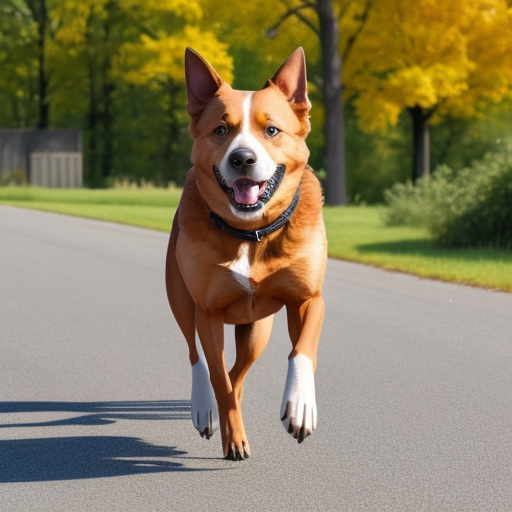

In [14]:
import numpy as np
from PIL import Image

def latent_to_img(latents_input):
    # decode image
    with torch.no_grad():
        decode_image = vae_model.decode(
            latents_input
            , return_dict = False
        )[0][0]

    decode_image =  (decode_image / 2 + 0.5).clamp(0, 1)

    # move latent data from cuda to cpu
    decode_image = decode_image.to("cpu")

    # convert torch tensor to numpy array
    numpy_img = decode_image.detach().numpy()

    # covert image array from (width, height, channel) to (channel, width, height)
    numpy_img_t = numpy_img.transpose(1,2,0)

    # map image data to 0, 255, and convert to to int number
    numpy_img_t_01_255 = (numpy_img_t*255).round().astype("uint8")

    # shape the pillow image object from the numpy array
    return Image.fromarray(numpy_img_t_01_255)

latents_2 = (1 / 0.18215) * latents_sd
pil_img = latent_to_img(latents_2)
pil_img

## Our own image-to-image Stable DIffusion pipeline

In [20]:
# prepare latents
shape = torch.Size([1, 4, 64, 64])
device = "cuda"
noise_tensor = torch.randn(
    shape
    , generator = None
    , dtype     = torch.float16
).to("cuda")

strength = 0.3
# scale the initial noise by the standard deviation required by the scheduler
latents = latents_input*strength + noise_tensor*scheduler.init_noise_sigma

In [22]:
inference_steps = 20
scheduler.set_timesteps(inference_steps, device = "cuda")

timesteps = scheduler.timesteps

In [23]:
# inference
guidance_scale = 7.5
latents_sd = torch.clone(latents)
for i,t in enumerate(timesteps):
    print(i,t)
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents_sd] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    
    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input
            , t
            , encoder_hidden_states=prompt_embeds
            , return_dict = False
        )[0]
    
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    latents_sd = scheduler.step(noise_pred, t, latents_sd, return_dict=False)[0]

0 tensor(999., device='cuda:0')
1 tensor(946.4211, device='cuda:0')
2 tensor(893.8421, device='cuda:0')
tensor(841.2632, device='cuda:0')
4 tensor(788.6842, device='cuda:0')
tensor(736.1053, device='cuda:0')
6 tensor(683.5263, device='cuda:0')
tensor(630.9474, device='cuda:0')
8 tensor(578.3684, device='cuda:0')
tensor(525.7895, device='cuda:0')
10 tensor(473.2105, device='cuda:0')
tensor(420.6316, device='cuda:0')
12 tensor(368.0526, device='cuda:0')
tensor(315.4737, device='cuda:0')
14 tensor(262.8947, device='cuda:0')
tensor(210.3158, device='cuda:0')
16 tensor(157.7368, device='cuda:0')
tensor(105.1579, device='cuda:0')
18 tensor(52.5789, device='cuda:0')
tensor(0., device='cuda:0')


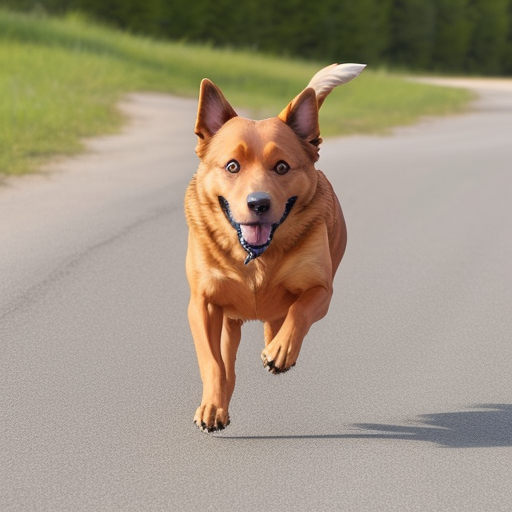

In [24]:
# recover image from latent
import numpy as np
from PIL import Image

def latent_to_img(latents_input):
    # decode image
    with torch.no_grad():
        decode_image = vae_model.decode(
            latents_input
            , return_dict = False
        )[0][0]

    decode_image =  (decode_image / 2 + 0.5).clamp(0, 1)

    # move latent data from cuda to cpu
    decode_image = decode_image.to("cpu")

    # convert torch tensor to numpy array
    numpy_img = decode_image.detach().numpy()

    # covert image array from (width, height, channel) to (channel, width, height)
    numpy_img_t = numpy_img.transpose(1,2,0)

    # map image data to 0, 255, and convert to to int number
    numpy_img_t_01_255 = (numpy_img_t*255).round().astype("uint8")

    # shape the pillow image object from the numpy array
    return Image.fromarray(numpy_img_t_01_255)

latents_2 = (1 / 0.18215) * latents_sd
pil_img = latent_to_img(latents_2)
pil_img

## Image-to-image pipeline in one cell

20
tensor(999., device='cuda:0')
tensor(946.4211, device='cuda:0')
tensor(893.8421, device='cuda:0')
tensor(841.2632, device='cuda:0')
tensor(788.6842, device='cuda:0')
tensor(736.1053, device='cuda:0')
tensor(683.5263, device='cuda:0')
tensor(630.9474, device='cuda:0')
tensor(578.3684, device='cuda:0')
tensor(525.7895, device='cuda:0')
tensor(473.2105, device='cuda:0')
tensor(420.6316, device='cuda:0')
tensor(368.0526, device='cuda:0')
tensor(315.4737, device='cuda:0')
tensor(262.8947, device='cuda:0')
tensor(210.3158, device='cuda:0')
tensor(157.7368, device='cuda:0')
tensor(105.1579, device='cuda:0')
tensor(52.5789, device='cuda:0')
tensor(0., device='cuda:0')
0 tensor(999., device='cuda:0')
1 tensor(946.4211, device='cuda:0')
2 tensor(893.8421, device='cuda:0')
tensor(841.2632, device='cuda:0')
4 tensor(788.6842, device='cuda:0')
tensor(736.1053, device='cuda:0')
6 tensor(683.5263, device='cuda:0')
tensor(630.9474, device='cuda:0')
8 tensor(578.3684, device='cuda:0')
tensor(525.789

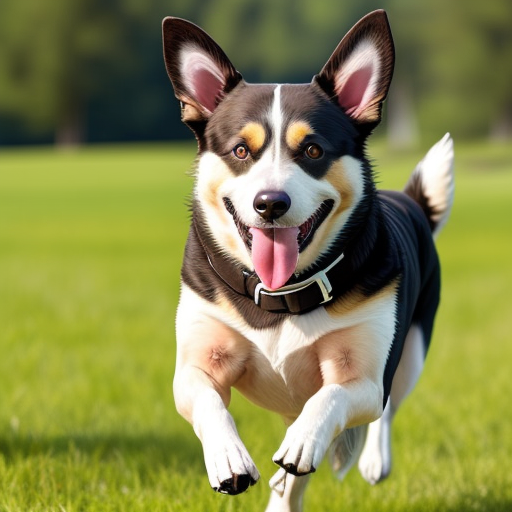

In [18]:
# load guided image
from diffusers.utils import load_image
image   = load_image("dog.png")

# preprocess image
def preprocess(image):
    import numpy as np

    # convert image from 0 ~ 255 to 0 ~ 1
    image_array     = np.array(image).astype(np.float16)/255.0

    # convert the number from 0 ~ 1 to -1 ~ 1
    image_array     = image_array * 2.0 - 1.0    

    # transform the image array from width,height,channel to channel,width,height
    image_array_cwh = image_array.transpose(2,0,1)

    # add batch dimension 
    image_array_cwh = np.expand_dims(image_array_cwh, axis = 0)
    return image_array_cwh

image_array_cwh = preprocess(image)

# image to latent
import torch
from diffusers import AutoencoderKL

# Initialize VAE model
vae_model = AutoencoderKL.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder = "vae"
    , torch_dtype = torch.float16
).to("cuda:0")

def image_to_latent(image_array_cwh):
    # load image with torch
    image_array_cwh = torch.from_numpy(image_array_cwh)
    image_array_cwh_cuda = image_array_cwh.to(
        "cuda:0"
    )
    
    # encode to latent 
    with torch.no_grad(): 
        latents = vae_model.encode(image_array_cwh_cuda).latent_dist.sample()
    return latents

latents_input = image_to_latent(image_array_cwh)

#input_prompt = "a running dog, playing a football"
input_prompt = "a running dog"

# input tokenizer and clip embedding model
from transformers import CLIPTokenizer,CLIPTextModel
import torch

# initialize tokenizer
clip_tokenizer = CLIPTokenizer.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder = "tokenizer"
    , dtype = torch.float16
)
input_tokens = clip_tokenizer(
    input_prompt
    , return_tensors="pt"
)["input_ids"]
input_tokens

# initialize CLIP text encoder model
clip_text_encoder = CLIPTextModel.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder = "text_encoder"
    , torch_dtype =torch.float16
).to("cuda")

# encode token ids to embeddings
with torch.no_grad(): 
    prompt_embeds = clip_text_encoder(
        input_tokens.to("cuda")
    )[0]
    
# prepare neg prompt embeddings
uncond_tokens = "blur"

# get the prompt embedding length
max_length = prompt_embeds.shape[1]

# generate negtive prompt tokens with the same lenght of prompt
uncond_input_tokens = clip_tokenizer(
    uncond_tokens
    , padding = "max_length"
    , max_length = max_length
    , truncation = True
    , return_tensors = "pt"
)["input_ids"]

# generate the negative embeddings
with torch.no_grad(): 
    negative_prompt_embeds = clip_text_encoder(
        uncond_input_tokens.to("cuda")
    )[0]

# concat prompt and neg prompt embeddings
prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

# Euler scheduelr
from diffusers import EulerDiscreteScheduler as Euler

# initialize scheduler from a pretrained checkpoint
scheduler = Euler.from_pretrained(
    #"runwayml/stable-diffusion-v1-5"
    "stablediffusionapi/deliberate-v2"
    , subfolder = "scheduler"
    , torch_dtype = torch.float16
)

inference_steps = 20
scheduler.set_timesteps(inference_steps, device = "cuda")

timesteps = scheduler.timesteps
print(len(timesteps))
for t in timesteps:
    print(t)
    
# Initialize Stabel Diffusion UNet
import torch
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder ="unet"
    , torch_dtype = torch.float16
).to("cuda")

# prepare latents
shape = torch.Size([1, 4, 64, 64])
device = "cuda"
noise_tensor = torch.randn(
    shape
    , generator = None
    , dtype     = torch.float16
).to("cuda")

strength = 0.3
# scale the initial noise by the standard deviation required by the scheduler
latents = latents_input*strength + noise_tensor*scheduler.init_noise_sigma

# inference
guidance_scale = 7.5
latents_sd = torch.clone(latents)
for i,t in enumerate(timesteps):
    print(i,t)
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents_sd] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    
    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input
            , t
            , encoder_hidden_states=prompt_embeds
            , return_dict = False
        )[0]
    
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    latents_sd = scheduler.step(noise_pred, t, latents_sd, return_dict=False)[0]
    
# recover image from latent
import numpy as np
from PIL import Image

def latent_to_img(latents_input):
    # decode image
    with torch.no_grad():
        decode_image = vae_model.decode(
            latents_input
            , return_dict = False
        )[0][0]

    decode_image =  (decode_image / 2 + 0.5).clamp(0, 1)

    # move latent data from cuda to cpu
    decode_image = decode_image.to("cpu")

    # convert torch tensor to numpy array
    numpy_img = decode_image.detach().numpy()

    # covert image array from (width, height, channel) to (channel, width, height)
    numpy_img_t = numpy_img.transpose(1,2,0)

    # map image data to 0, 255, and convert to to int number
    numpy_img_t_01_255 = (numpy_img_t*255).round().astype("uint8")

    # shape the pillow image object from the numpy array
    return Image.fromarray(numpy_img_t_01_255)
    
latents_2 = (1 / 0.18215) * latents_sd
pil_img = latent_to_img(latents_2)
pil_img